# Pixel-wise Prediction (PixelNet Concept) with a Simple CNN

This notebook demonstrates how to build a simple Convolutional Neural Network (CNN) for a pixel-level prediction task. This is in the spirit of architectures like **PixelNet** or Fully Convolutional Networks (FCNs), which aim to produce an output for every pixel in the input image (e.g., for semantic segmentation).

**Note:** The original [PixelNet paper](https://arxiv.org/abs/1609.06694) describes a specific, complex architecture. To satisfy the request for a **simple CNN**, we are not implementing that paper. Instead, we are building a simple FCN that demonstrates the *goal* of pixel-wise prediction.

### Our Task:
1.  **Dataset:** We will use the inbuilt `keras.datasets.mnist` dataset.
2.  **Goal:** Instead of classifying the digit (0-9), we will perform **binary segmentation**. The model must learn to output a mask that separates the **digit pixels (Class 1)** from the **background pixels (Class 0)**.
3.  **Model:** We will build a simple, custom CNN from scratch with `Conv2D` layers that output a segmentation mask of the same 28x28 size as the input.

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Load and Preprocess the Data

We load MNIST. We only need the images (`x_train`, `x_test`) as our input features. 

The segmentation *labels* (`y_train`, `y_test`) will be **created from the images themselves**. Any pixel that is *not* pure black will be considered part of the "digit" mask.

In [ ]:
# Load the dataset 
# We don't need the classification labels (y_train_class), so we use 
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data() 

# --- 1. Preprocess Input Images (x) --- 

# Normalize pixel values to be between 0 and 1 
x_train = x_train.astype("float32") / 255.0 
x_test = x_test.astype("float32") / 255.0 

# Add a channel dimension (MNIST is grayscale, so 1 channel) 
# Shape changes from (60000, 28, 28) to (60000, 28, 28, 1) 
x_train = np.expand_dims(x_train, -1)  
x_test = np.expand_dims(x_test, -1) 

# --- 2. Create Segmentation Masks (y) --- 
# Our "ground truth" is a mask where any pixel > 0 is 1 (digit) 
# and any pixel == 0 is 0 (background). 
# We use a small threshold (0.1) instead of 0 to be safe with float precision. 
y_train_masks = (x_train > 0.1).astype("float32") 
y_test_masks = (x_test > 0.1).astype("float32") 

print(f"Input images shape (x_train): {x_train.shape}") 
print(f"Output masks shape (y_train_masks): {y_train_masks.shape}") 

Input images shape (x_train): (60000, 28, 28, 1)
Output masks shape (y_train_masks): (60000, 28, 28, 1)


### Visualize an Example

Let's check our data to make sure the input image and the target mask look correct.

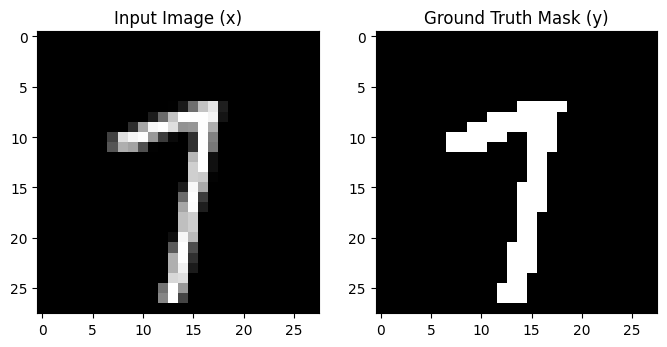

In [ ]:
idx = 42  # Pick a random image

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Input Image (x)")
plt.imshow(x_train[idx].squeeze(), cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Ground Truth Mask (y)")
plt.imshow(y_train_masks[idx].squeeze(), cmap="gray")

plt.show() 

## Step 2: Build the Simple Pixel-wise CNN

We'll build a simple CNN using the Keras Functional API.

**Key architectural choices:**
1.  `padding='same'`: We use this in all our `Conv2D` layers. This ensures the output feature map has the **same height and width** as the input. This is critical for pixel-wise prediction, as we don't want the image to shrink.
2.  **No Pooling Layers:** We avoid `MaxPooling2D` layers, which would downsample the image and lose spatial resolution.
3.  **Final Layer:** The last layer is a `Conv2D` with:
    * `filters=1`: It produces one channel of output (the binary mask).
    * `kernel_size=(1, 1)`: A 1x1 convolution is a standard way to map the final feature channels to the desired output mask.
    * `activation='sigmoid'`: This squashes the output for each pixel to be between 0 and 1, representing the *probability* that the pixel belongs to the "digit" class.

In [ ]:
def build_simple_pixel_net(input_shape=(28, 28, 1)):
    inputs = keras.Input(shape=input_shape)

    # A simple stack of convolutional layers 
    # We use 'same' padding to maintain the 28x28 resolution 
    conv1 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(inputs) 
    conv2 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(conv1) 
    conv3 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(conv2) 

    # This is the final output layer. 
    # It uses a 1x1 convolution and sigmoid activation to produce a 
    # 28x28x1 probability mask.
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid", padding="same")(conv3)

    model = keras.Model(inputs, outputs)
    return model

model = build_simple_pixel_net()

# For a pixel-wise binary classification, we use 'binary_crossentropy' loss.
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics=["accuracy"])

model.summary()

2025-10-23 20:24:42.476401: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-10-23 20:24:42.477123: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-10-23 20:24:42.478438: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-10-23 20:24:42.479018: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-23 20:24:42.479558: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 1)      │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,441 (36.88 KB)

 Trainable params: 9,441 (36.88 KB)

 Non-trainable params: 0 (0.00 B)

## Step 3: Train the Model

We train the model. Note that the input (`x_train`) and the target (`y_train_masks`) have the same dimensions (except for the last channel, which is 1 for both).

In [ ]:
print("Starting model training...")
history = model.fit(
    x_train,
    y_train_masks,
    batch_size=32,
    epochs=5,  # 5 epochs is enough for a good demonstration
    validation_data=(x_test, y_test_masks)
) 
print("Training complete.") 

Starting model training...
Epoch 1/5


2025-10-23 20:24:49.037086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.9957 - loss: 0.0179 - val_accuracy: 0.9990 - val_loss: 0.0026
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.9994 - loss: 0.0018 - val_accuracy: 0.9995 - val_loss: 0.0014
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9996 - loss: 0.0012 - val_accuracy: 0.9996 - val_loss: 9.8604e-04
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.9997 - loss: 9.1930e-04 - val_accuracy: 0.9998 - val_loss: 6.5634e-04
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - accuracy: 0.9997 - loss: 7.6584e-04 - val_accuracy: 0.9997 - val_loss: 6.4517e-04
Training complete.


## Step 4: Evaluate and Visualize Results

Now, let's use our trained model to make predictions on the test set and see how well it learned to segment the digits.

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


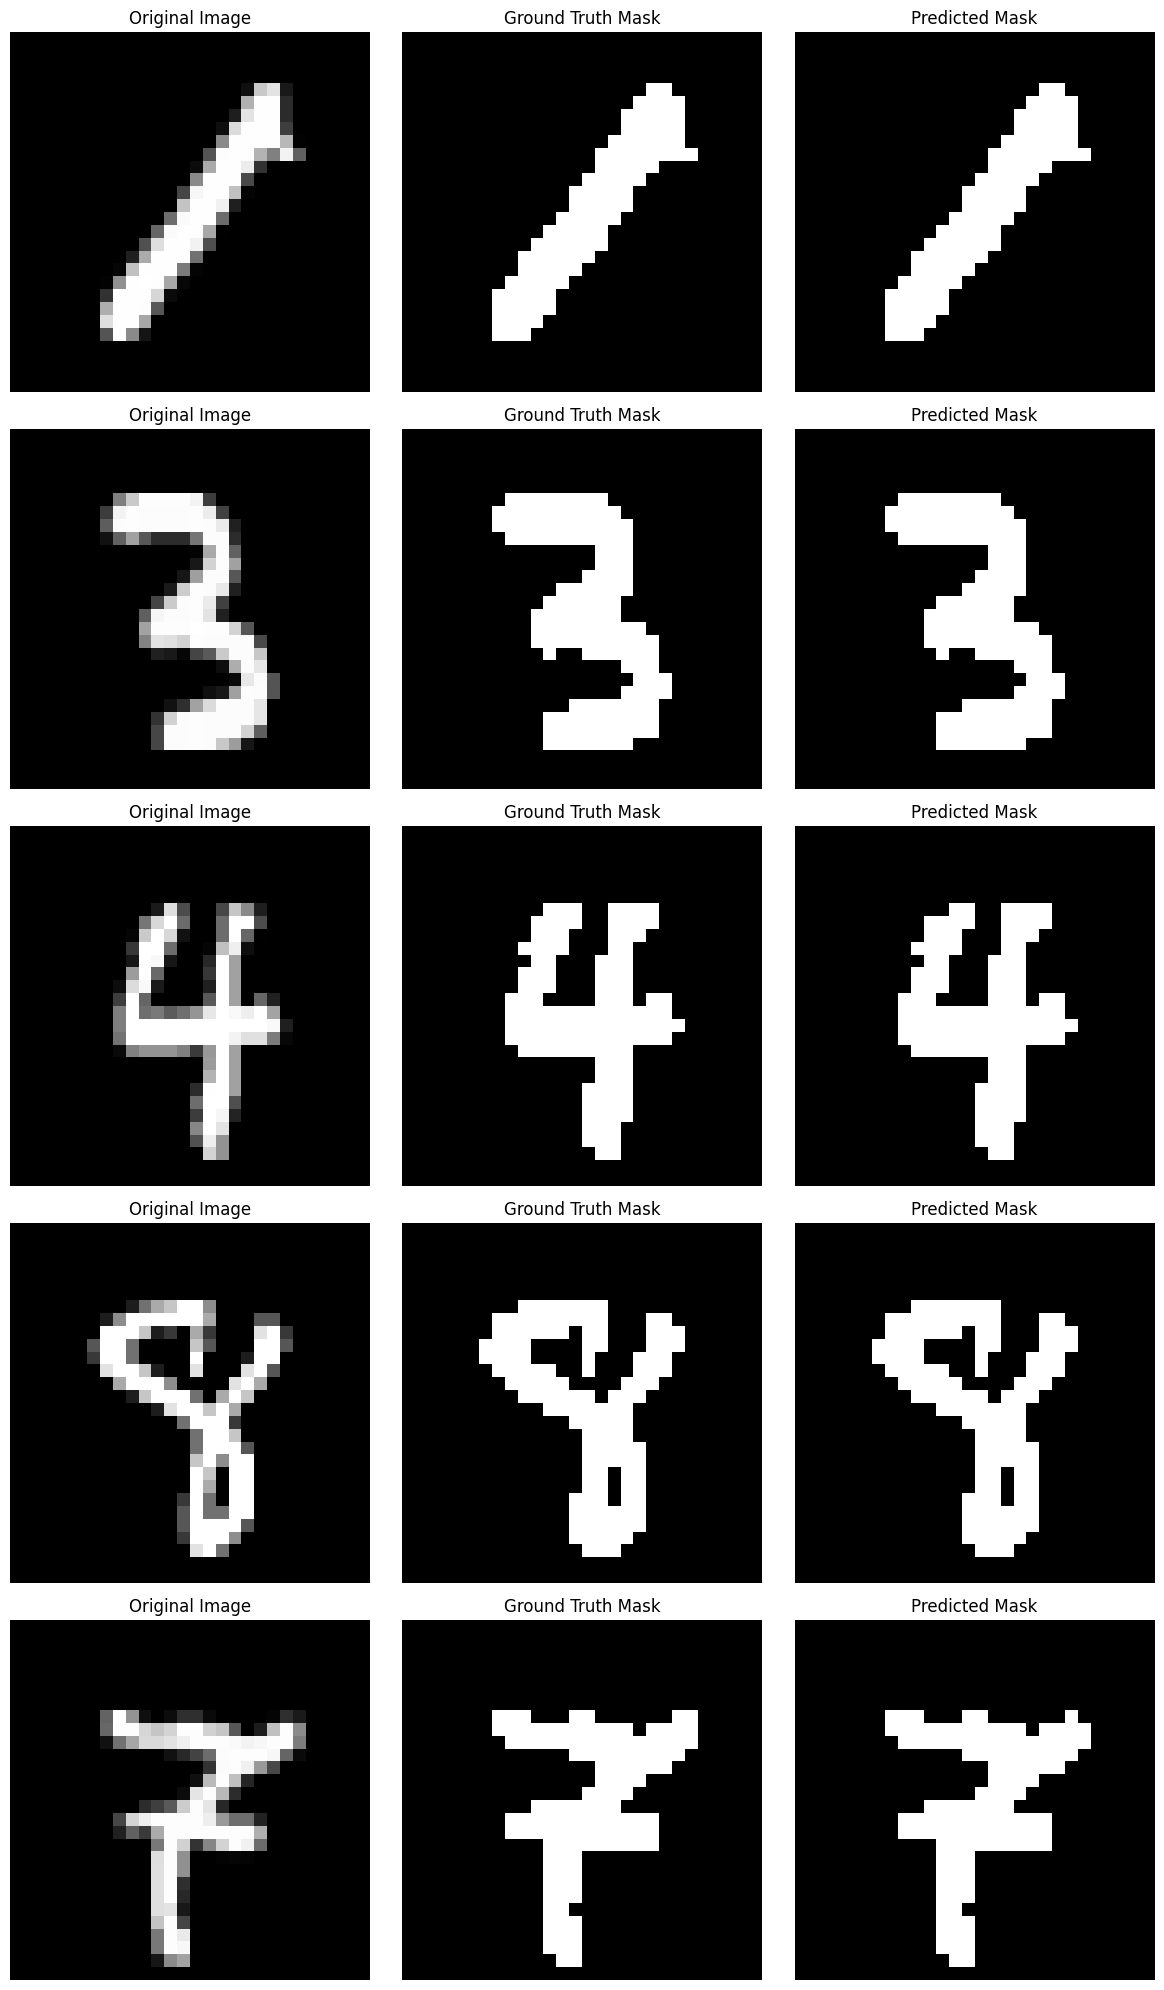

In [ ]:
# Get predictions on the test set
predicted_masks = model.predict(x_test)

# Function to display the original image, true mask, and predicted mask
def show_predictions(n=5):
    plt.figure(figsize=(12, n * 4))
    for i in range(n):
        # Pick a random test image
        idx = np.random.randint(0, len(x_test))

        # Original Image
        ax = plt.subplot(n, 3, i * 3 + 1)
        plt.title("Original Image")
        plt.imshow(x_test[idx].squeeze(), cmap="gray")
        plt.axis("off")

        # True Mask
        ax = plt.subplot(n, 3, i * 3 + 2)
        plt.title("Ground Truth Mask")
        plt.imshow(y_test_masks[idx].squeeze(), cmap="gray") 
        plt.axis("off") 

        # Predicted Mask
        # We apply a 0.5 threshold to the sigmoid output for visualization
        ax = plt.subplot(n, 3, i * 3 + 3)  
        plt.title("Predicted Mask") 
        plt.imshow(predicted_masks[idx].squeeze() > 0.5, cmap="gray") 
        plt.axis("off")  
    
    plt.tight_layout() 
    plt.show() 

show_predictions(n=5) 